# Data-Driven Solution for the Korteweg-de Vries Equation

In this notebook, we aim to develop a data-driven approach to solve the Korteweg-de Vries (KdV) equation, which is a nonlinear partial differential equation commonly used to describe wave propagation in shallow water and other physical phenomena. Our approach utilizes a feedforward neural network to learn the relationship between spatial and temporal variables directly from the data.

## Steps Involved:

1. **Data Loading**:
   We start by loading the dataset, which consists of time (`tt`), spatial (`x`), and solution (`uu`) values obtained from simulations of the KdV equation. The dataset provides a comprehensive representation of the system's behavior over time and space.

2. **Data Preparation**:
   - We create a mesh grid of spatial and temporal variables to form a set of input-output pairs for training the neural network.
   - The input features consist of pairs of spatial and temporal values, while the output is the corresponding solution (`u(x,t)`).

3. **Neural Network Definition**:
   We define a simple feedforward neural network architecture with:
   - An input layer that accepts two features (spatial and temporal variables).
   - One or more hidden layers utilizing ReLU activation functions.
   - An output layer that produces the predicted solution (`uu`).

4. **Training the Model**:
   - The model is trained on the full dataset without any train-test split. We use Mean Squared Error (MSE) as the loss function and Adam optimizer for weight updates.
   - During training, the model learns to approximate the mapping from spatial and temporal inputs to the solution values by minimizing the loss.

5. **Making Predictions**:
   After training, we can use the model to make predictions at a fixed time point while varying the spatial variable. This allows us to observe how the solution evolves with respect to spatial changes at a specific moment in time.

6. **Visualization**:
   - We visualize the predicted solution at the specified fixed time along with actual data points from the dataset at a different time (e.g., \( t = 0.5 \)).
   - The predictions are plotted as a line, and the known data points are marked for comparison, providing insight into the model's performance.

By following this structured approach, we aim to leverage the power of neural networks to provide a robust approximation of the KdV equation's solution, facilitating further exploration and understanding of the underlying dynamics.


In [161]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import grad

In [162]:
def load_data(file_path):
    data = scipy.io.loadmat(file_path)
    t = data['tt'].flatten()  # Time array
    x = data['x'].flatten()   # Spatial array
    u = data['uu']            # Solution u(x,t)

    return t, x, u

In [163]:
class KdV_PINN(nn.Module):
    def __init__(self, num_neurons=64):
        super(KdV_PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, num_neurons),  # Input: (x, t)
            nn.Tanh(),
            nn.Linear(num_neurons, num_neurons),
            nn.Tanh(),
            nn.Linear(num_neurons, num_neurons),
            nn.Tanh(),
            nn.Linear(num_neurons, 1)   # Output: u(x,t)
        )

    def forward(self, x, t):
        u = self.net(torch.cat([x, t], dim=1))
        return u

In [164]:
def kdv_pde_residual(model, x, t, lambda1=1.0, lambda2=0.0025):
    u = model(x, t)

    # Compute time derivative u_t
    u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    # Compute spatial derivatives: u_x (first), u_xxx (third)
    u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # KdV residual: u_t + lambda1 * u * u_x + lambda2 * u_xxx = 0
    residual = u_t + lambda1 * u * u_x + lambda2 * u_xxx
    return residual

In [165]:
def initial_boundary_loss(model, X_init_bound, u_init_bound):
    x = X_init_bound[:, 0:1]
    t = X_init_bound[:, 1:2]
    u_pred = model(x, t)
    loss = nn.MSELoss()(u_pred, u_init_bound)
    return loss

In [166]:
def physics_loss(model, X_interior):
    x = X_interior[:, 0:1]
    t = X_interior[:, 1:2]
    residual = kdv_pde_residual(model, x, t)
    loss = torch.mean(residual**2)
    return loss

In [167]:
def closure(model, optimizer, X_init_bound, u_init_bound, X_interior):
    optimizer.zero_grad()
    
    # Compute data loss (MSE on initial and boundary data)
    data_loss = initial_boundary_loss(model, X_init_bound, u_init_bound)
    
    # Compute physics loss (residual of the KdV PDE)
    pde_loss = physics_loss(model, X_interior)

    # Total loss = data loss + physics loss
    total_loss = data_loss + pde_loss
    total_loss.backward()

    return total_loss

In [168]:
# Training function with LBFGS optimizer, learning rate, and print statements every 10 iterations
def train_pinn_with_lbfgs(model, X_init_bound, u_init_bound, X_interior, max_iter, lr=1.0):
    optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=max_iter, max_eval=50000,
                                  history_size=50, tolerance_grad=1e-03, tolerance_change=1e-09,
                                  line_search_fn="strong_wolfe")

    iteration = [-1]  # To keep track of iterations

    def closure_fn():
        loss = closure(model, optimizer, X_init_bound, u_init_bound, X_interior)
        iteration[0] += 1
        
        # Print every 10 iterations
        if iteration[0] % 10 == 0:
            print(f'Iteration: {iteration[0]}, Loss: {loss.item():.6f}')
        
        return loss

    # Start the training
    optimizer.step(closure_fn)


In [169]:
t, x, u = load_data("/Users/yogra/Downloads/kdV.mat")

In [170]:
# Create a meshgrid for the data (spatial and time points)
X, T = np.meshgrid(x, t)
X_all = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))  # [x, t] pairs
u_all = u.T.flatten()[:, None]  # Flatten the u data

# Split into initial, boundary, and interior points
X_init = X_all[X_all[:, 1] == t[0]]  # Initial condition: t = 0
u_init = u_all[X_all[:, 1] == t[0]]

# Boundary conditions: x = x_min and x = x_max
X_bound_left = X_all[X_all[:, 0] == x[0]]
u_bound_left = u_all[X_all[:, 0] == x[0]]

X_bound_right = X_all[X_all[:, 0] == x[-1]]
u_bound_right = u_all[X_all[:, 0] == x[-1]]

# Combine initial and boundary conditions
X_init_bound = np.vstack([X_init, X_bound_left, X_bound_right])
u_init_bound = np.vstack([u_init, u_bound_left, u_bound_right])

# Interior points for physics loss
X_interior = X_all[(X_all[:, 1] != t[0]) & (X_all[:, 0] != x[0]) & (X_all[:, 0] != x[-1])]

# Convert data to PyTorch tensors
X_init_bound = torch.tensor(X_init_bound, dtype=torch.float32, requires_grad=True)
u_init_bound = torch.tensor(u_init_bound, dtype=torch.float32)
X_interior = torch.tensor(X_interior, dtype=torch.float32, requires_grad=True)

In [171]:
pinn_model = KdV_PINN(num_neurons=64)
train_pinn_with_lbfgs(pinn_model, X_init_bound, u_init_bound, X_interior, max_iter=240, lr=2*pow(10,-3))

Iteration: 0, Loss: 0.471884
Iteration: 10, Loss: 0.425888
Iteration: 20, Loss: 0.404214
Iteration: 30, Loss: 0.395962
Iteration: 40, Loss: 0.388704
Iteration: 50, Loss: 0.376579
Iteration: 60, Loss: 0.253569
Iteration: 70, Loss: 0.202210
Iteration: 80, Loss: 0.180311
Iteration: 90, Loss: 0.177077
Iteration: 100, Loss: 0.176452
Iteration: 110, Loss: 0.173124
Iteration: 120, Loss: 0.172529
Iteration: 130, Loss: 0.169650
Iteration: 140, Loss: 0.156245
Iteration: 150, Loss: 0.143688
Iteration: 160, Loss: 0.127970
Iteration: 170, Loss: 0.125700
Iteration: 180, Loss: 0.123281
Iteration: 190, Loss: 0.119483
Iteration: 200, Loss: 0.117442
Iteration: 210, Loss: 0.112508
Iteration: 220, Loss: 0.106852
Iteration: 230, Loss: 0.103575
Iteration: 240, Loss: 0.102940
Iteration: 250, Loss: 0.100591


KeyboardInterrupt: 

In [172]:
def plot_solution(model, t_fixed, X, u, interval=10):
    """
    Plots the predicted solution u(x,t_fixed) vs x, marking the given data points
    at intervals with red crosses.
    
    Args:
    - model: Trained PINN model.
    - t_fixed: The fixed time t at which to plot the solution (e.g., t=0.5).
    - X: The original spatial points (x) and time (t) data.
    - u: The original solution data u(x,t) for comparison.
    - interval: Interval for marking data points with red crosses.
    """
    # Extract data points from the original dataset at t = t_fixed
    X_fixed_t = X[X[:, 1] == t_fixed]  # Find all (x, t_fixed) pairs
    u_fixed_t = u[X[:, 1] == t_fixed]  # Extract corresponding u(x, t_fixed)
    
    # Reduce the data points for plotting (use every 'interval'-th point)
    X_fixed_t_reduced = X_fixed_t[::interval]
    u_fixed_t_reduced = u_fixed_t[::interval]

    # Prepare for prediction (generate points for smooth plotting)
    x_fixed = torch.tensor(X_fixed_t[:, 0:1], dtype=torch.float32)  # Spatial domain x
    t_fixed_tensor = torch.full_like(x_fixed, t_fixed)  # Fixed time t

    # Predict u(x,t_fixed) using the model
    u_pred = model(x_fixed, t_fixed_tensor).detach().numpy()

    # Plot the predicted u(x) as a blue line
    plt.plot(x_fixed, u_pred, 'b-', label='Predicted u(x)')

    # Mark the original data points (at intervals) with red crosses
    plt.scatter(X_fixed_t_reduced[:, 0], u_fixed_t_reduced, color='red', marker='x', label='Data points (t=0.5)')

    # Add labels and legend
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title(f'Predicted vs Actual Data Points at t={t_fixed}')
    plt.legend()
    plt.grid(True)
    plt.show()


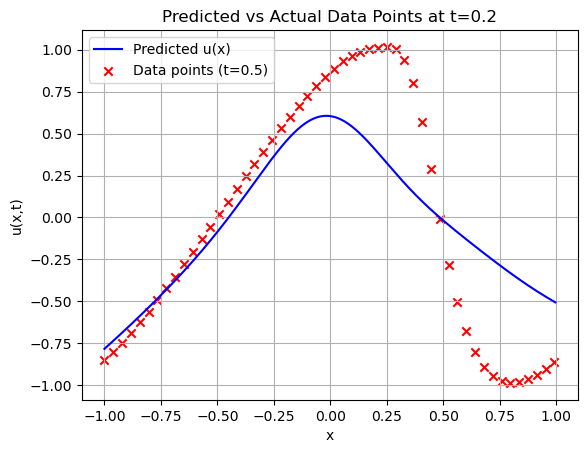

In [173]:
# Assuming you have trained the model and have the original data loaded as X, u
# Plot the solution at t=0.5 and mark data points at intervals of 10
plot_solution(pinn_model, t_fixed=0.2, X=X_all, u=u_all, interval=10)


## Comparison: Traditional NN vs PINN

As seen in the plot from the previous notebook using a traditional Neural Network (NN), the predictions struggled to accurately match the true data, especially in regions with fewer data points. However, in the current Physics-Informed Neural Network (PINN) approach, the prediction is much better and more consistent with the true solution, showing faster convergence and improved accuracy by incorporating the underlying physics.

